In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
path="/content/gdrive/MyDrive/"

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
df_agb = pd.read_csv(path + "age_gender_bkts.csv.zip")

In [ ]:
df_agb.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [ ]:
#check for missing values
df_agb.isna().sum()

age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64

There are no null values amongst its features.

As the ages are given in bins, convert this to a numerical value so that we can increase its versaility should the need arise (that is, it can be used both as a categorical and a continuous feature). As the bin size is reasonably small, we can define a new feature, mean_age which can represent ages without too much loss of information. The mean_age will be the average of the upper and lower range for that particular bin

In [ ]:
#Convert 100+ into a bin.
df_agb['age_bucket'] = df_agb['age_bucket'].apply(lambda x: '100-104' if x == '100+' else x)
#Define mean_age feature
df_agb['mean_age'] = df_agb['age_bucket'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1]))/2)
df_agb = df_agb.drop('age_bucket', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,year,mean_age
0,AU,male,1.0,2015.0,102.0
1,AU,male,9.0,2015.0,97.0
2,AU,male,47.0,2015.0,92.0
3,AU,male,118.0,2015.0,87.0
4,AU,male,199.0,2015.0,82.0


In [ ]:
df_agb['country_destination'].value_counts()

AU    42
CA    42
DE    42
ES    42
FR    42
GB    42
IT    42
NL    42
PT    42
US    42
Name: country_destination, dtype: int64

In [ ]:
df_agb['gender'].value_counts()

male      210
female    210
Name: gender, dtype: int64

The gender can also be turned into a categorical binary variable.  represent male with 0 and female with 1. Do this just in case we require this variable to function as a numerical quantity.

In [ ]:
df_agb['gender'] = df_agb['gender'].apply(lambda x: 0 if x == 'male' else 1)
df_agb['gender'].value_counts()

0    210
1    210
Name: gender, dtype: int64

In [ ]:
df_agb['year'].value_counts()

2015.0    420
Name: year, dtype: int64

There is only value available for the year feature. Therefore, it makes no sense to keep this feature as it doesn't add any information about the data available to us. So we drop this feature.

In [ ]:
df_agb = df_agb.drop('year', axis=1)
df_agb.head()

,country_destination,gender,population_in_thousands,mean_age
0,AU,0,1.0,102.0
1,AU,0,9.0,97.0
2,AU,0,47.0,92.0
3,AU,0,118.0,87.0
4,AU,0,199.0,82.0


In [ ]:
df_con = pd.read_csv(path + "countries.csv.zip")

In [ ]:
df_con.head()

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [ ]:
df_ses = pd.read_csv(path + "sessions.csv.zip")

In [ ]:
df_ses.head(10)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [ ]:
df_ses.shape

(10567737, 6)

Will have to replace unknown values with Nan in the dataset

In [ ]:
df_ses['action'] = df_ses['action'].replace('-unknown-', np.nan)
df_ses['action_type'] = df_ses['action_type'].replace('-unknown-', np.nan)
df_ses['action_detail'] = df_ses['action_detail'].replace('-unknown-', np.nan)

Plot for seconds elapsed

<ipython-input-25-92d46f477c52>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])


<Axes: xlabel='secs_elapsed', ylabel='Density'>

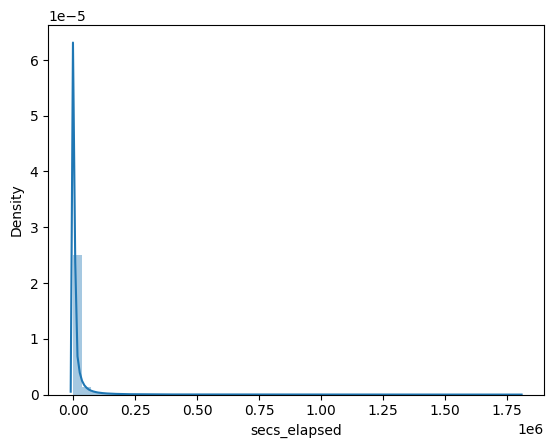

In [ ]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

In [ ]:
df_ses['secs_elapsed'].describe()

count    1.043171e+07
mean     1.940581e+04
std      8.888424e+04
min      0.000000e+00
25%      2.290000e+02
50%      1.147000e+03
75%      8.444000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

The average number of seconds per session is 19450 seconds whereas the median value is 1147 seconds. This suggests a heavily skewed dataset with some outlier observations influencing the mean of the distribution.

In [ ]:
len(df_ses[df_ses['secs_elapsed'].isnull()])

136031

There are more than 136,000 fields for which we do not know the value. We need to either drop or interpolate these values. For the time being, let us fill the unavailable values with the median of the distribution. We use median since, as was mentioned earlier, this distribution is heavily influenced by outliers.

In [ ]:
median_secs = df_ses['secs_elapsed'].median()
df_ses['secs_elapsed'] = df_ses['secs_elapsed'].fillna(median_secs)

In [ ]:
df_ses['secs_elapsed'].describe()

count    1.056774e+07
mean     1.917078e+04
std      8.833430e+04
min      0.000000e+00
25%      2.370000e+02
50%      1.147000e+03
75%      8.193000e+03
max      1.799977e+06
Name: secs_elapsed, dtype: float64

the interpolation has not significantly altered the summary statistics of the distribution. This is a good option for filling in the null values for the time being.

In [ ]:
null_action = df_ses[(df_ses['action_type'].isnull()) | (df_ses['action_detail'].isnull()) | (df_ses['action'].isnull()) ]
null_action.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0
6,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,115.0
9,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,683.0


In [ ]:
null_action.shape

(2237000, 6)

In [ ]:
len(null_action['action'].drop_duplicates())

270

There are over 2.23 million fields that have incomplete information about the action, action type or action detail. This is approximately 20% of the data that we possess. Additionally, there are 270 types of action for which we have null values, so examining them one by one is simply not feasible manually.

Since this is not our training dataset, we will not drop the values. We shall keep because it is possible to extract information even from rows which have null columns.

In [ ]:
df_ses[df_ses['device_type'].isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed


In [ ]:
df_ses['device_type'] = df_ses['device_type'].replace('-unknown-', np.nan)

In [ ]:
df_ses['device_type'].value_counts()

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64

In [ ]:
len(df_ses[df_ses['device_type'].isnull()])

211279

As with the action variables, we will not drop these values since this is not the dataset we will be applying our machine learning algorithms to. We will replace the unknown strings with NaN

In [ ]:
df_train = pd.read_csv(path + 'train_users_2.csv.zip')

In [ ]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [ ]:
df_train.shape

(213451, 16)

In [ ]:
df_train['gender'] = df_train['gender'].replace('-unknown-', np.nan)
df_train['first_browser'] = df_train['first_browser'].replace('-unknown-', np.nan)

In [ ]:
df_train[df_train['first_device_type'].isnull()]

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination


The following features in the dataset have no null values:

date_account_created
timestamp_first_active
signup_method
signup_flow
language
affiliate_channel
affiliate_provider
signup_app
first_device_type
The following features in the dataset have null values:

date_first_booking
gender
age
first_affiliate_tracked
first_browser

In [ ]:
df_train.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                      95688
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser               27266
country_destination             0
dtype: int64

In [ ]:
df_train[df_train['age'] > 120].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,NaN,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US
1177,2th813zdx7,2010-07-25,20100725234419,2010-07-26,MALE,2013.0,facebook,3,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
1200,3amf04n3o3,2010-07-27,20100727190447,2010-07-29,FEMALE,2014.0,basic,2,en,direct,direct,untracked,Web,Windows Desktop,IE,US


notice that there are samples for which the age is much greater than 120 considering the oldest person is currently 114 years old. This is clearly polluted data and must be removed. replace these values with NaN to denote that we do not know the real age of these people.

In [ ]:
df_train['age'] = df_train['age'].apply(lambda x: np.nan if x > 120 else x)

statistical analysis:
understand the relationship between variables using the chi square test

check if there is a gender based preference for certain countries. In other words, does the gender of a person affect the first country s/he books an Airbnb in? To answer this question we will have to test the relationship between two categorical variables: Gender and Destination Country. Since the number of destination countries is multivariate, the Chi Square Square Significance Test.



assumptions:
check if there is a gender based preference for certain countries. In other words, does the gender of a person affect the first country she or he books an Airbnb in? Test the relationship between two categorical variables: Gender and Destination Country. Since the number of destination countries is multivariate, the Chi Square Square Significance Test.



In [ ]:
df_inf = df_train[(df_train['country_destination'] != 'NDF') & (df_train['country_destination'] != 'other') & (df_train['gender'] != 'OTHER') & (df_train['gender'].notnull())]
df_inf = df_inf[['id', 'gender', 'country_destination']]
df_inf.head()

,id,gender,country_destination
2,4ft3gnwmtx,FEMALE,US
6,lsw9q7uk0j,FEMALE,US
7,0d01nltbrs,FEMALE,US
8,a1vcnhxeij,FEMALE,US
10,yuuqmid2rp,FEMALE,US


In [ ]:
df_inf['gender'].value_counts()

FEMALE    28833
MALE      24278
Name: gender, dtype: int64

In [ ]:
df_inf['country_destination'].value_counts()

US    42151
FR     3297
IT     1790
GB     1563
ES     1530
CA      932
DE      774
NL      532
AU      395
PT      147
Name: country_destination, dtype: int64

Hypothesis Testing
For the hypothesis testing, we define the following:

Null Hypothesis: There is no relationship between country preference and the sex of the customer.
Alternate Hypothesis: There is a relationship between country preference and the sex of the customer.
We will assume our significance level,  α  to be 0.05.

In [ ]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
del observed.columns.name
observed = observed.set_index('gender')
observed

AttributeError: ignored

In [ ]:
observed = df_inf.pivot_table('id', ['gender'], 'country_destination', aggfunc='count').reset_index()
observed.columns.name = None  # Resetting the columns' name to None
observed = observed.set_index('gender')
observed

,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
gender,,,,,,,,,,
FEMALE,207,455,358,853,1962,881,1091,254,78,22694
MALE,188,477,416,677,1335,682,699,278,69,19457


In [ ]:
chi2, p, dof, expected = stats.chi2_contingency(observed)

In [ ]:
chi2

116.87183139602567

In [ ]:
p

5.830126955071572e-21

The p-value that we have obtained is less than our chosen significance level. Therefore, we reject the null hypothesis and accept the negating alterate hypothesis. There is a relationship between country preference and the sex of the customer. This information can prove extremely useful to us when performing feature engineering in later steps

look at the realtionship between signup method and the signup device. A preliminary querying of our dataframe tells us that most users signup either through the standard basic method or through Facebook. Additionally, they login using either a desktop browser, a mobile browser or a mobile app.

Does the type of device (mobile or computer) affect the signup method to Airbnb?

assumptions:
We will ignore the Google Signup Method as there are extremely few instances of it.
We will consider iOs, Moweb and Android to all be of the Mobile Device Type.

In [ ]:
df_signup = df_train[(df_train['signup_method'] != 'google')][['id', 'signup_method', 'signup_app']]
df_signup['device'] = df_signup['signup_app'].apply(lambda x: 'Computer' if x == 'Web' else 'Mobile')
df_signup.head()

,id,signup_method,signup_app,device
0,gxn3p5htnn,facebook,Web,Computer
1,820tgsjxq7,facebook,Web,Computer
2,4ft3gnwmtx,basic,Web,Computer
3,bjjt8pjhuk,facebook,Web,Computer
4,87mebub9p4,basic,Web,Computer


In [ ]:
df_signup['signup_method'].value_counts()

basic       152897
facebook     60008
Name: signup_method, dtype: int64

In [ ]:
df_signup['device'].value_counts()

Computer    182717
Mobile       30188
Name: device, dtype: int64

In [ ]:
df_signup = df_signup.pivot_table('id', ['device'], 'signup_method', aggfunc='count')
df_signup.index = ['Computer', 'Mobile']
df_signup.columns = ['Basic', 'Facebook']
df_signup

,Basic,Facebook
Computer,131237,51480
Mobile,21660,8528


In [ ]:
chi2, p, dof, expected = stats.chi2_contingency(df_signup, correction=False)

In [ ]:
chi2

0.07183824273421707

In [ ]:
p

0.7886788661023779

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. There is no relationship between device type and signup method.

two sample significance test

In [ ]:
df_signup.loc['Total'] = [ df_signup['Basic'].sum(), df_signup['Facebook'].sum()]
df_signup['Total'] = df_signup['Basic'] + df_signup['Facebook']
df_signup

,Basic,Facebook,Total
Computer,131237,51480,182717
Mobile,21660,8528,30188
Total,152897,60008,212905


In [ ]:
fb_prop = df_signup.loc['Mobile', 'Facebook']/df_signup.loc['Total', 'Facebook']
fb_std = df_signup.loc['Mobile', 'Facebook'] * ((1 - fb_prop) ** 2) + df_signup.loc['Computer', 'Facebook'] * ((0 - fb_prop) ** 2)
fb_std = np.sqrt(fb_std/df_signup.loc['Total', 'Facebook'])

fb_prop, fb_std

(0.14211438474870017, 0.3491674188640724)

In [ ]:
basic_prop = df_signup.loc['Mobile', 'Basic']/df_signup.loc['Total', 'Basic']
basic_std = df_signup.loc['Mobile', 'Basic'] * ((1 - basic_prop) ** 2) + df_signup.loc['Computer', 'Basic'] * ((0 - basic_prop) ** 2)
basic_std = np.sqrt(basic_std/df_signup.loc['Total', 'Basic'])

basic_prop, basic_std

(0.14166399602346677, 0.34870518816635054)

In [ ]:
h0_prop = 0

prop_diff = fb_prop - basic_prop
p_hat = (df_signup.loc['Mobile', 'Basic'] + df_signup.loc['Mobile', 'Facebook'])/(df_signup.loc['Total', 'Basic'] + df_signup.loc['Total', 'Facebook'])
var_diff = p_hat * (1- p_hat) * (1/df_signup.loc['Total', 'Basic'] + 1/df_signup.loc['Total', 'Facebook'])
sigma_diff = np.sqrt(var_diff)

prop_diff, sigma_diff

(0.0004503887252333971, 0.001680388342245922)

In [ ]:
z = (prop_diff - h0_prop) / sigma_diff
z

0.2680265709481359

In [ ]:
p = (1-stats.norm.cdf(z))*2
p

0.7886788661023794

The p-value obtained is higher than our chosen significance level. Therefore, we are not in a position to reject the null hypothesis. It stands. There is no relationship between device type and signup method.

Also notice that the p-values obtained for Two Sample Significance Test and Chi Square Significance Test (without Correction) is exactly the same

There is a relationship between gender and Airbnb Country Destination. In other words, the gender influences your country of choice.
There is no relationship between device type and signup method. The two variables are independent of each other.
The results obtained from Chi Square Significance Test and Two Sample Significance Test are exactly the same.

EDA

Country statistics

<ipython-input-70-1620bb6a85ed>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)


<Axes: xlabel='mean_age', ylabel='population_in_thousands'>

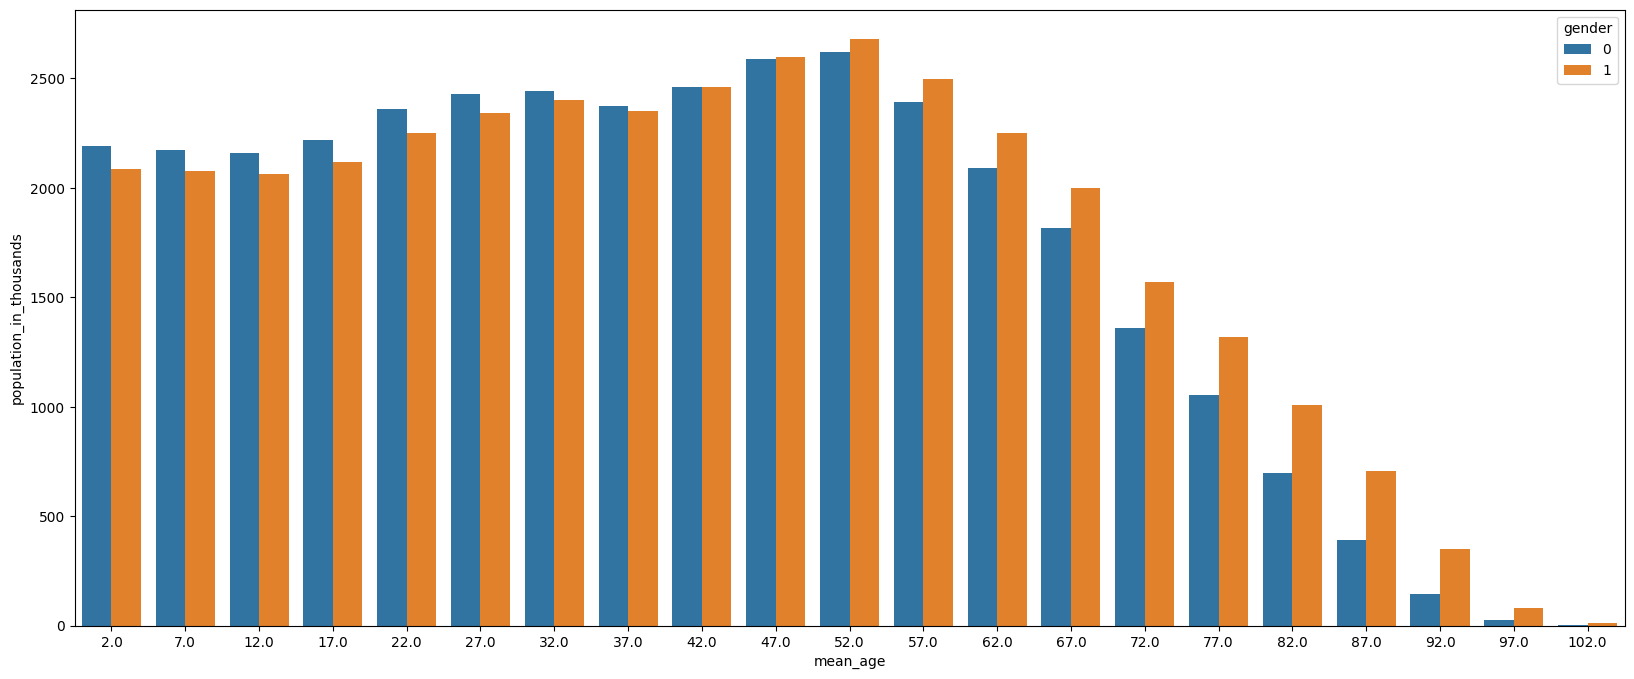

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='mean_age', y='population_in_thousands', hue='gender', data=df_agb, ci=None)

The countries that are represented in this statistic largely consist of an aging population. The largest groups are people with mean ages 47 years and 52 years.
The distribution resembles a skewed bell curve. The middle aged people occupy the largest share of the population, closely followed by the youth and finally, the old.
The population counts of young and middle aged people are fairly comparable. But as we transition towards old age (age > 57 years), the population count for every successive bucket decreases steadily.
Although it is not relevant, the sex ratio is skewed towards men for younger age groups but as the mean age increases, the ratio skews more towards women.

<Axes: xlabel='country_destination', ylabel='population_in_thousands'>

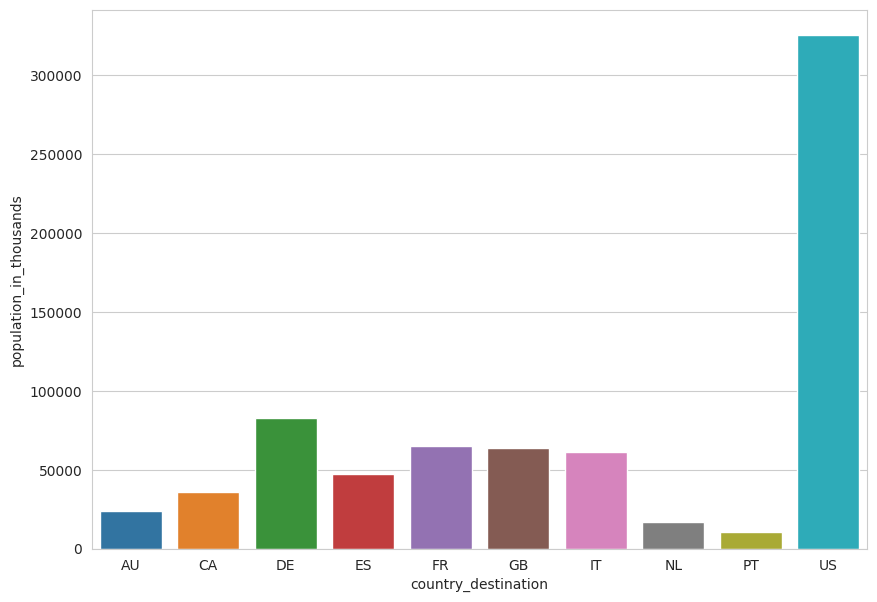

In [ ]:
#graph the population count in each country
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
pop_stats = df_agb.groupby('country_destination')['population_in_thousands'].sum()
sns.barplot(x=pop_stats.index, y=pop_stats)

The United States of America is clearly the most populated nation amongst the destination countries with a population of over 300 million. All the other countries in the list have a population less than 100 million.

create a bar plot of the distance of the country from the country of origin the US. construct a scatterplot between the frequency of booking in a country and the distance of the country.

<Axes: xlabel='country_destination', ylabel='distance_km'>

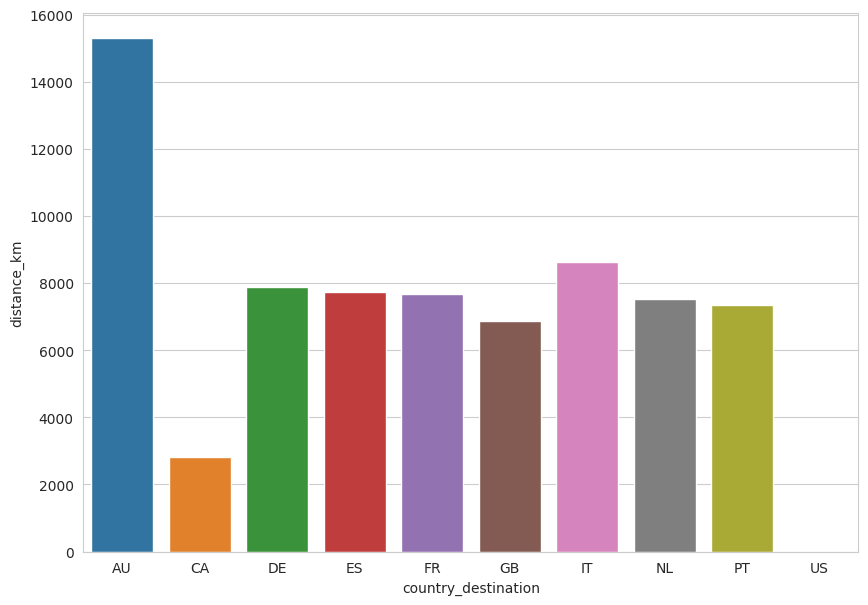

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='country_destination', y='distance_km', data=df_con)

In [ ]:
country_popularity = df_train[(df_train['country_destination'] != 'NDF') &
(df_train['country_destination'] != 'other')]['country_destination'].value_counts()

In [ ]:
country_distance = pd.Series(df_con['distance_km'])
country_distance.index = df_con['country_destination']

In [ ]:
language_distance = pd.Series(df_con['language_levenshtein_distance'])
language_distance.index = df_con['country_destination']

In [ ]:
country_area = pd.Series(df_con['destination_km2'])
country_area.index = df_con['country_destination']

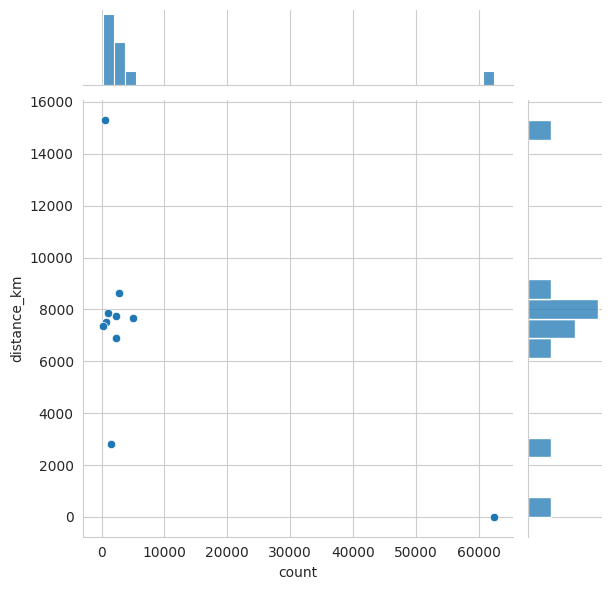

In [ ]:
df_dp = pd.concat([country_popularity, country_distance, language_distance, country_area], axis=1)
df_dp.columns = ['count', 'distance_km', 'language', 'area']
sns.jointplot(x='count', y='distance_km', data=df_dp)

In [ ]:
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_dp['count'], df_dp['distance_km'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")



Pearson Correlation Coefficient: -0.6484642400863146
P-value: 0.04254889990179417


pearsonr = -0.65; p = 0.043

There is a strong negative correlation of -0.65. People overwhelmingly prefer booking in the United States than any other country in the world. We can attribute this preference to distance. Let us check if this holds true for just the interantional countries as well.

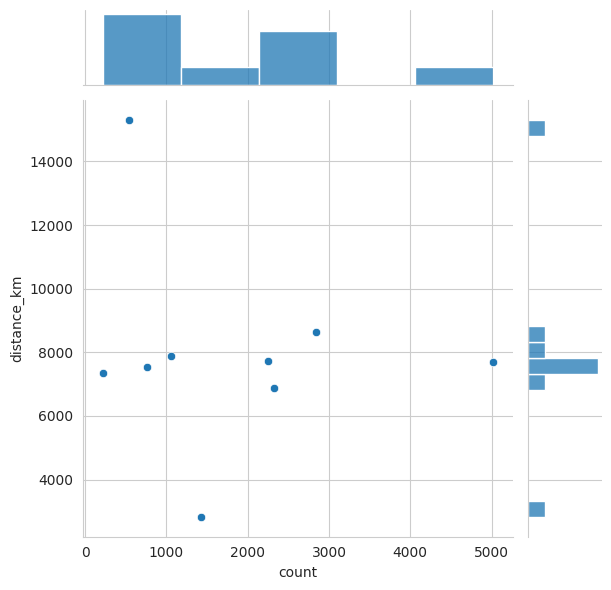

In [ ]:
sns.jointplot(x='count', y='distance_km', data=df_dp.drop('US'))

In [ ]:
df_dp_filtered = df_dp[df_dp.index != 'US']

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df_dp_filtered['count'], df_dp_filtered['distance_km'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.17594466240935686
P-value: 0.6506866405490174


The correlation, with United States out of the equation, is much lower at -0.18. However, there is still a negative correlation between the two quantities.

Next, let us check if the language spoken in a particular country influences the number of bookings in that country. To calculate this metric, we will use the Language Levenshtein Distance of each country's official language from English. This data is already made available to us by Airbnb. Again, like physical distance, my guess is that lower the levenshtein distance, greater the number of bookings in that country.

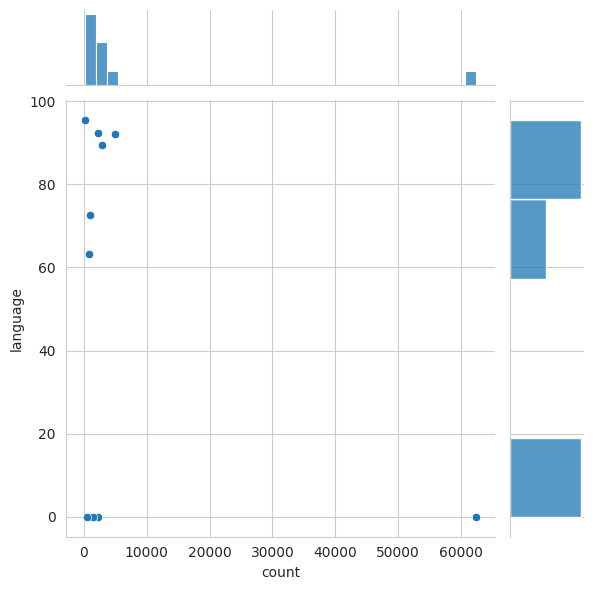

In [ ]:
sns.jointplot(x='count', y='language', data=df_dp)

In [ ]:
correlation, p_value = pearsonr(df_dp['count'], df_dp['language'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.3781984499393646
P-value: 0.2812147047224902


There seems to be a medium negative correlation of -0.38 between the two quantities. This suggests that people indeed prefer countries that speak English. But is that really the case? Let us remove United States, the home country, once again and recalculate our correlation coefficient.

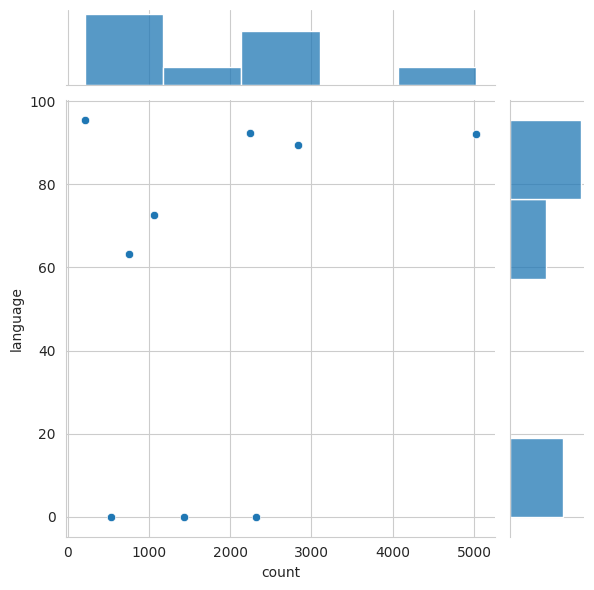

In [ ]:
sns.jointplot(x='count', y='language', data=df_dp.drop('US'))

In [ ]:
df_dp_filtered = df_dp[df_dp.index != 'US']

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df_dp_filtered['count'], df_dp_filtered['language'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.2842388570652174
P-value: 0.45853489094554595


The result of this visualisation is extremely interesting.

We see that when United States is removed from the list of countries, there is actually a positive correlation between language distance and booking frequency.
At first glance, this may suggest that people prefer countries with different language (and therefore culture) while travelling abroad.
Another way of looking at it would be that Europe is an extremely popular travel destination for Americans and they tend to prefer it to other English Speaking countries like Canada and Australia. So this may have nothing to do with language difference as it may have to do with destination preference.

check if the size of the country has anything to do with booking preference. Like the previous two cases, we have data on the size of each country.

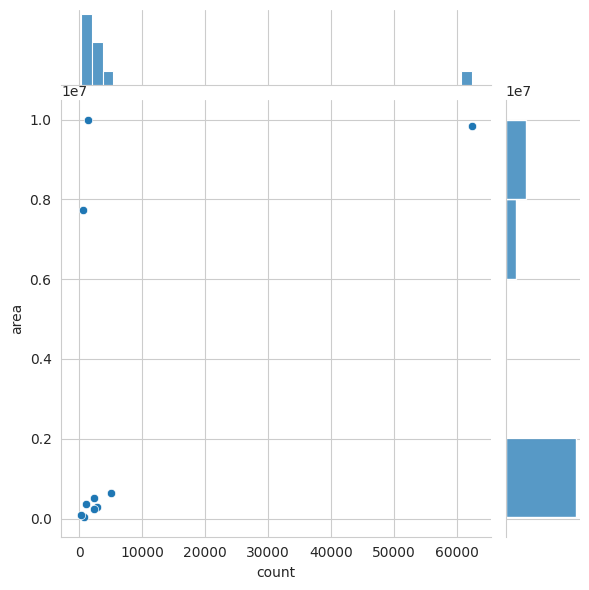

In [ ]:
sns.jointplot(x='count', y='area', data=df_dp)

In [ ]:
correlation, p_value = pearsonr(df_dp['count'], df_dp['area'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: 0.5389902049556756
P-value: 0.10790831227077446


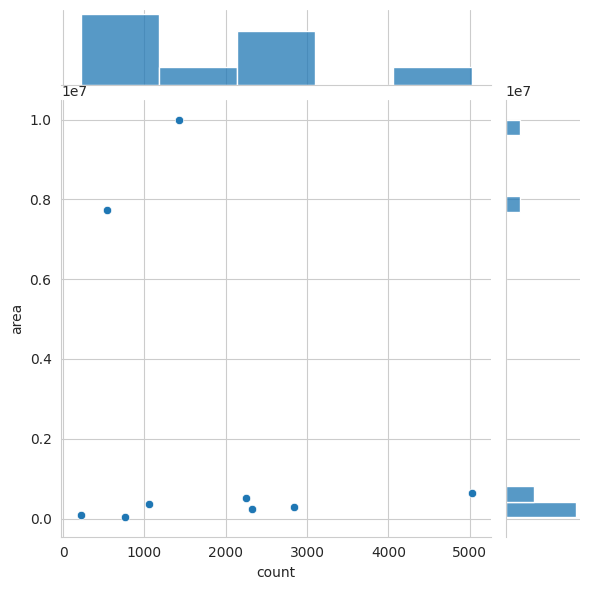

In [ ]:
sns.jointplot(x='count', y='area', data=df_dp.drop('US'))

In [ ]:
df_dp_filtered = df_dp[df_dp.index != 'US']

# Calculate the Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df_dp_filtered['count'], df_dp_filtered['area'])

print(f"Pearson Correlation Coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson Correlation Coefficient: -0.25729522442458896
P-value: 0.5039042635493616


The results with area closely resemble what we've gained from our tests on language distance. Overall, there is a positive correlation between the size of the country and the booking preference. This is largely because the United States is a large country (the second largest in this list).

When the US is removed however, the data showcases a negative correlation. Again, as with the case of language, this may have nothing to do with country size but destination preference. European countries are usually small in size but extremely popular among American tourists.

SESSION STATS

<ipython-input-96-92d46f477c52>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])


<Axes: xlabel='secs_elapsed', ylabel='Density'>

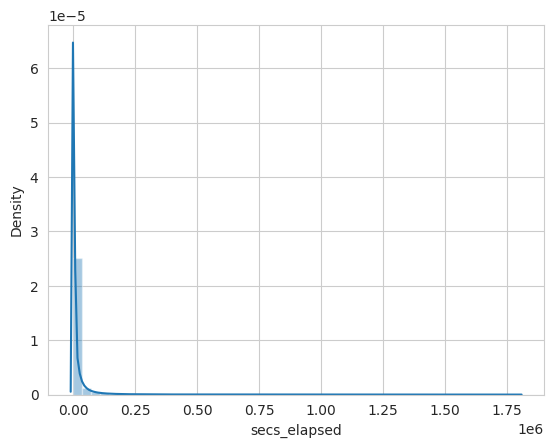

In [ ]:
sns.distplot(df_ses[df_ses['secs_elapsed'].notnull()]['secs_elapsed'])

almost all sessions were less than 5000 seconds long. Let us look deeper into these sessions.

<ipython-input-97-02eb41444dbf>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])


<Axes: xlabel='secs_elapsed', ylabel='Density'>

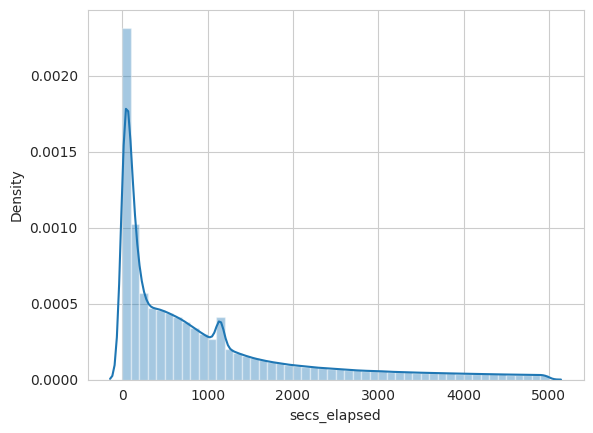

In [ ]:
sns.distplot(df_ses[(df_ses['secs_elapsed'].notnull()) & (df_ses['secs_elapsed'] < 5000)]['secs_elapsed'])

In [ ]:
len(df_ses[df_ses['secs_elapsed'] < 1000])/len(df_ses[df_ses['secs_elapsed'].notnull()])

0.4672638049186879

Almost 47% of all sessions were less than 1000 seconds long. This strongly suggests a decreasing exponential distribution of seconds elapsed on each session. In other words, as the number of seconds increases, the number of instances of sessions requiring that much time exponentially decreases.

 create a bar plot of all devices used by various users in interacting with the Airbnb Website and App.

<Axes: xlabel='count', ylabel='device_type'>

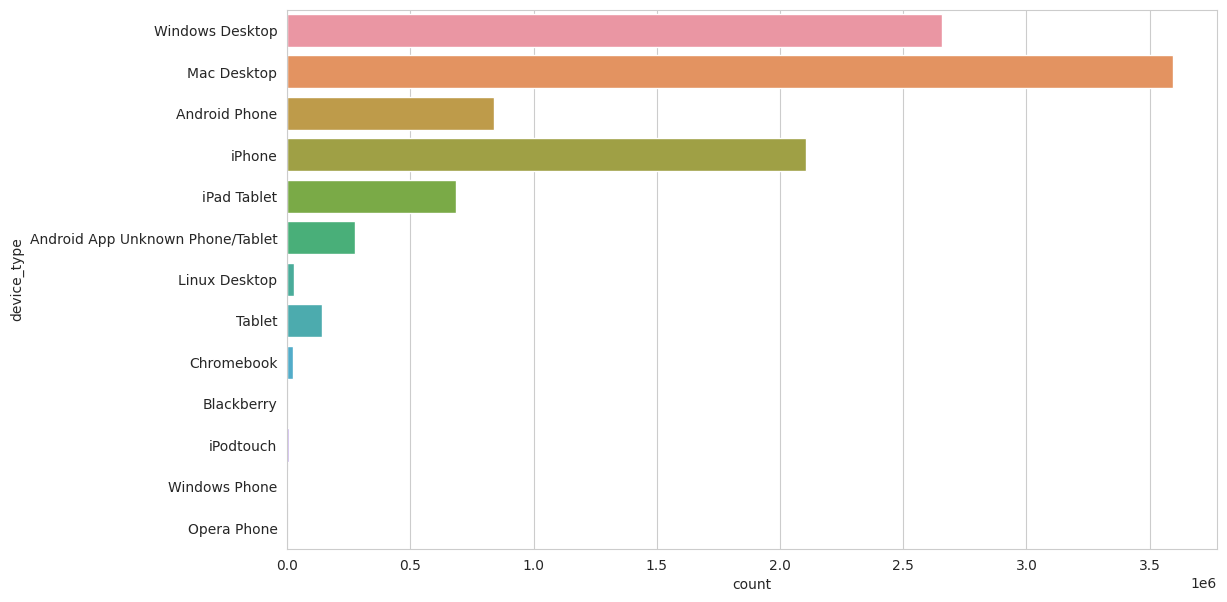

In [ ]:
plt.figure(figsize=(12,7))
sns.countplot(y='device_type', data=df_ses)

The Mac Desktop is the most popular device among Airbnb Users, followed by the Windows Desktop. An interesting insight is that Apple Products are extremely popular with Airbnb Users. The iPhone, iPad and the Mac all appear in the list of top 5 most popular devices.

Training Users Analysis



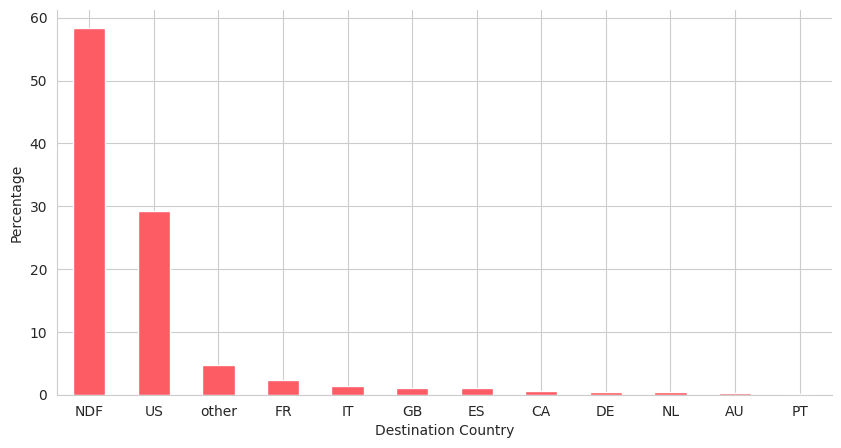

In [ ]:
plt.figure(figsize=(10,5))
country_share = df_train['country_destination'].value_counts() / df_train.shape[0] * 100
country_share.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

close to 60% of users have never booked an Airbnb. Among the users that have, they have overwhelmingly chosen United States as their first destination. When training our machine learning model, it is of interest to us to separate the bookers from the non bookers. Subsequent classification amongst bookers would yield a high accuracy as we could use the imbalance of classes in favor.

 create stacked barplots to gain insight into various kinds of users the people who have booked, the countries they have chosen, etc.

In [ ]:
classes = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']

The stacked bar plot will the major tool of visualisation in the EDA. The idea was picked up from kevinwu06's excellent notebook on Airbnb Exploratory Analysis.

The stacked bar chart gives us a collection of proportionately colored bars where each color represents a class (or the destination). Since there are more than 10 classes, I chose to forego the legend. The colors we are concerned with are dark blue (bottom bar) which corresponds to the NDF class and blue (second bottom bar) which corresponds to the US Class. As we have already seen, these two classes form the majority and therefore, will occupy most of the area of each bar. Each bar has been normalized with respect to its size.

What we will try to deduce is the proportion of the bar which belongs to the non booking class (dark blue). If this is large, it means that particular segment are unlikely to book an Airbnb. If small, it means they are more inclined to do so.

In [ ]:
def stacked_bar(feature):
    ctab = pd.crosstab([df_train[feature].fillna('Unknown')], df_train.country_destination, dropna=False).apply(lambda x: x/x.sum(), axis=1)
    ctab[classes].plot(kind='bar', stacked=True, colormap='terrain', legend=False)

In [ ]:
#gender
sns.countplot(df_train['gender'].fillna('Unknown'))

ValueError: ignored

We see that the users whose gender is unknown form the majority. Out of the users whose gender is known, there are more females than males. This can suggest two things:

There are more female Airbnb Users than male
Women are more likely to disclose their gender than men.
One very interesting point of note is that people who haven't marked their gender are less likely to book an Airbnb. Also, people who have marked themselves as 'other' are more likely than any other group to make a booking. This might not be a very potent insight since the other group is a negligible proportion of the population.

<ipython-input-107-66daf80dc621>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['age'].dropna())


<Axes: xlabel='age', ylabel='Density'>

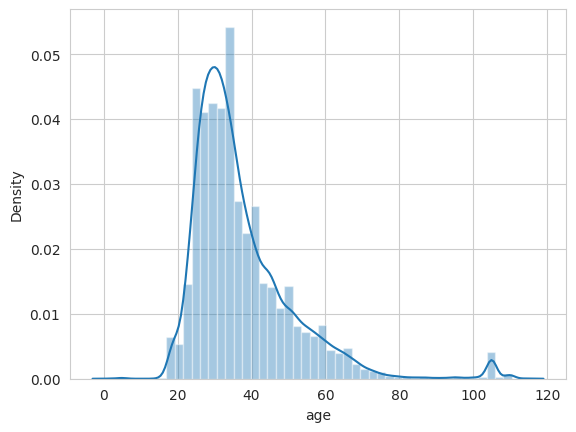

In [ ]:
#age
sns.distplot(df_train['age'].dropna())

Are some age groups more likely to book in a particular destination?

(10.0, 75.0)

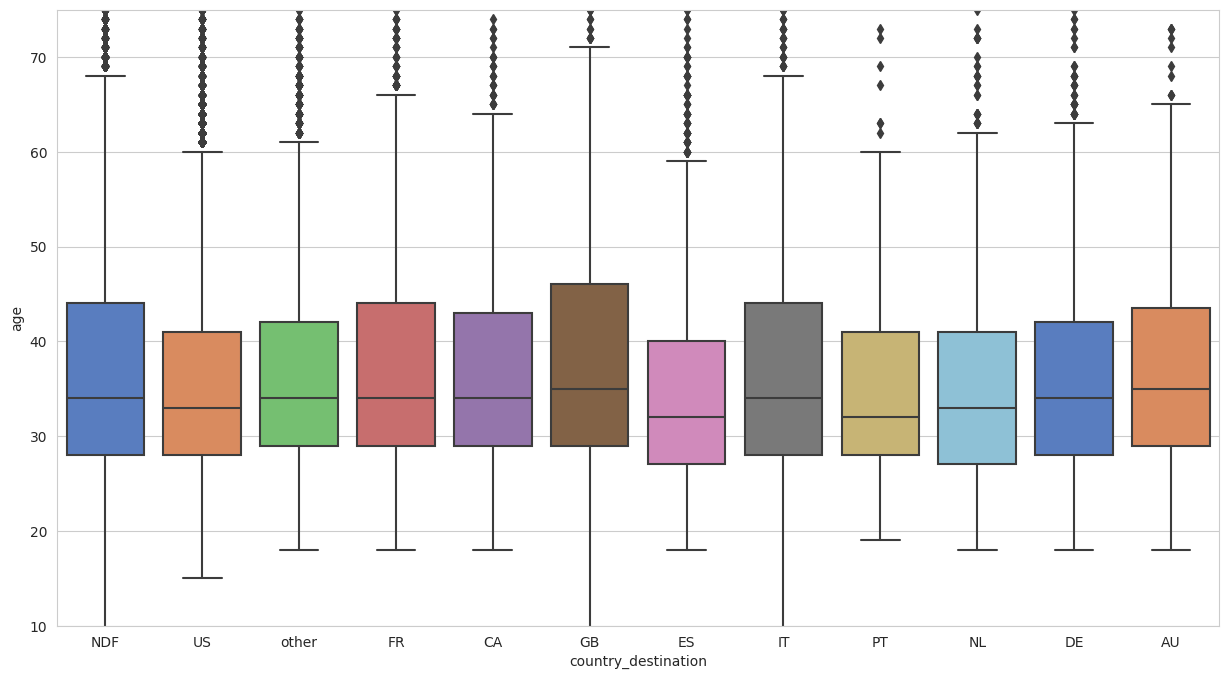

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='country_destination', y='age', data=df_train, palette="muted", ax =ax)
ax.set_ylim([10, 75])

From the boxplot constructed, we find that the distribution is more or less the same for every country. Great Britain has the highest median age of travellers and Spain is more popular amongst younger travellers.

In [ ]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

In [ ]:
df_train['age_group'] = df_train['age'].apply(set_age_group)

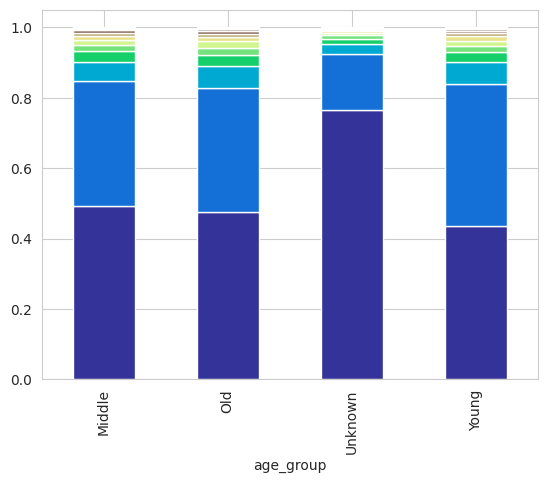

In [ ]:
stacked_bar('age_group')

We define a new feature age_group to group our users into 4 Age Groups:

People younger than 40 are labelled as young.
People aged between 40 and 60 years are labelled as middle aged.
People aged greater than 60 years are labelled old.
People with unknown ages are labelled unknown.
We discover that people who have not disclosed their ages are least likely to book an Airbnb. Out of the users whose age we know, Middle Aged People are most likely to book an Airbnb. Although it must be noted that there isn't a very significant difference amongst the three groups.

Signup Method
In a previous section, we already established that basic and Facebook were the most popular signup methods. Google was rarely used.

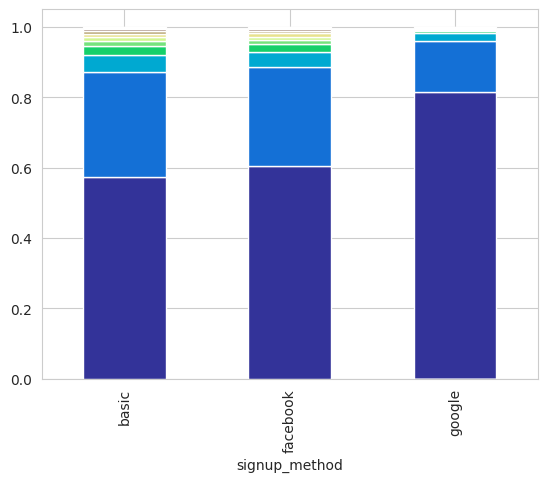

In [ ]:
stacked_bar('signup_method')

We discover that people who use basic signup method are most likely to book an Airbnb whereas people who use google are least likely to make a booking.

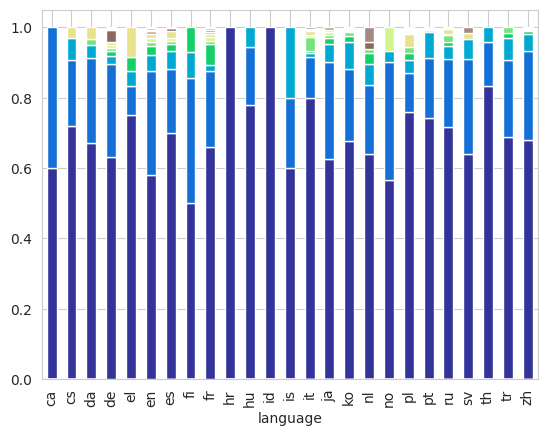

In [ ]:
stacked_bar('language')

We see that people who speak Hungarian and Indonesian made almost no bookings. People who spoke Finnish made the most bookings amongst all languages. However since the users are American, we can safely assume that the non English users consitute a minortiy.

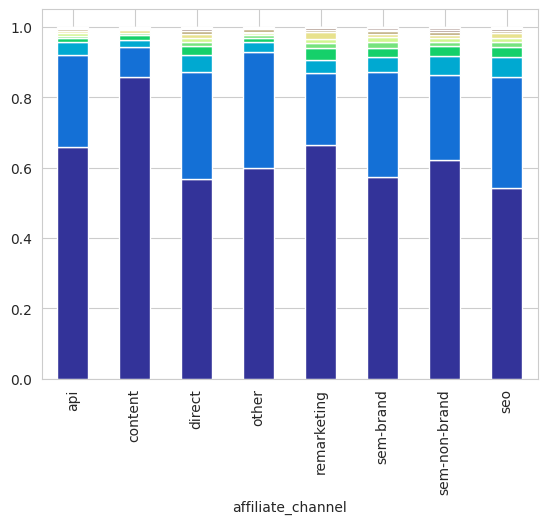

In [ ]:
stacked_bar('affiliate_channel')

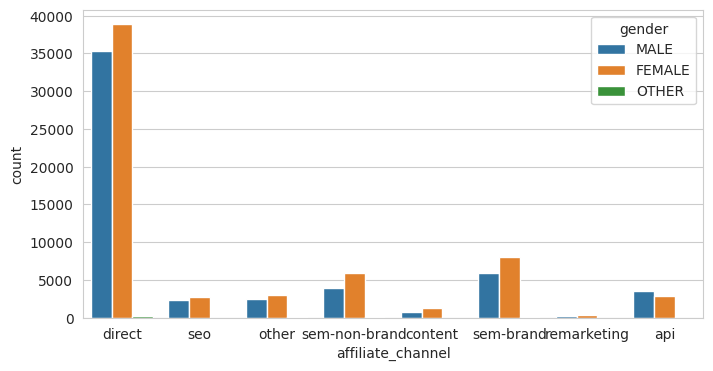

In [ ]:
plt.figure(figsize=(8, 4))

# Use sns.countplot with the 'affiliate_channel' column and add hue for better visualization
sns.countplot(data=df_train, x='affiliate_channel', hue='gender')

# Show the plot
plt.show()

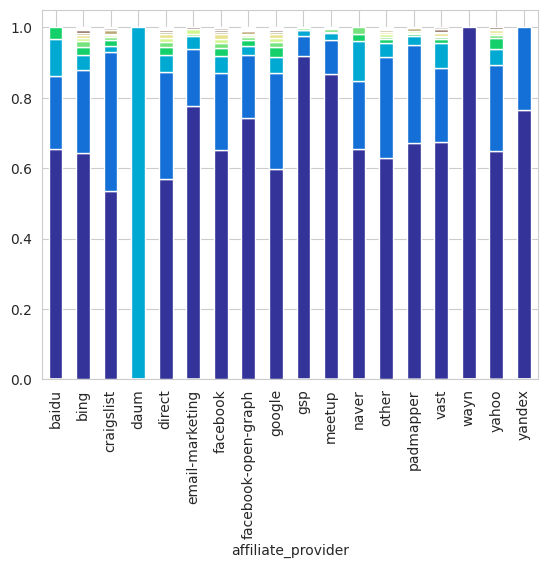

In [ ]:
stacked_bar('affiliate_provider')

<Axes: xlabel='affiliate_channel', ylabel='count'>

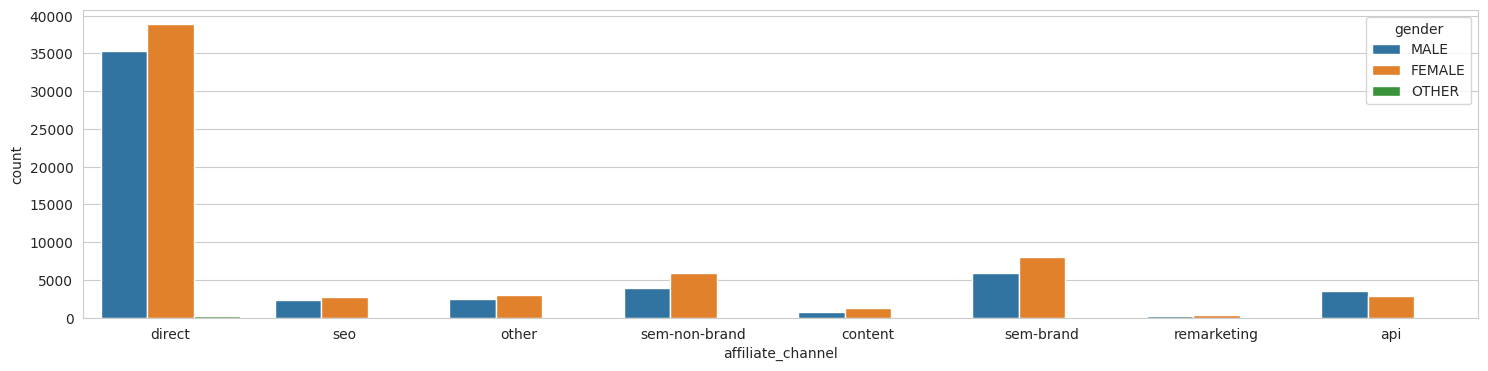

In [ ]:
plt.figure(figsize=(18,4))
sns.countplot(data= df_train, x='affiliate_channel', hue='gender')

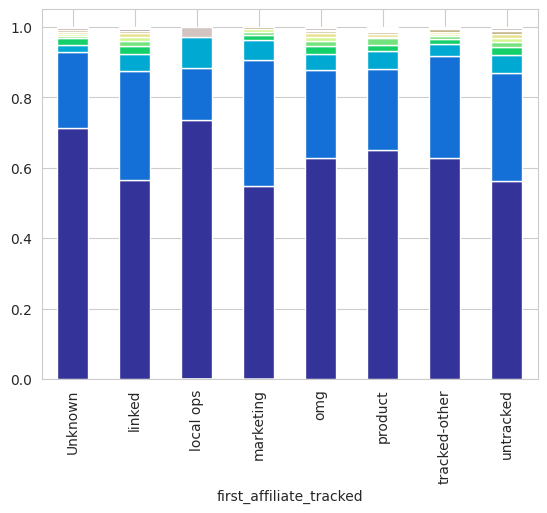

In [ ]:
stacked_bar('first_affiliate_tracked')

The Direct Channel has the most number of conversions to bookings whereas the Content Channel has the least.
Direct and Google are the most popular affiliate providers.
Wayn has the least percentage of conversions whereas Daum has the most. However, we must take this with a pinch of salt as it might be the case that the number of sample points of these categories are extremely few in number (as the count plot suggests).
Apart from the above, Google and Craigslist have a good percentage of conversions.
People with Marketing afilliates were most likely to book. People whose first affiliate was tracked as Local Ops or was Unknown were least likely.

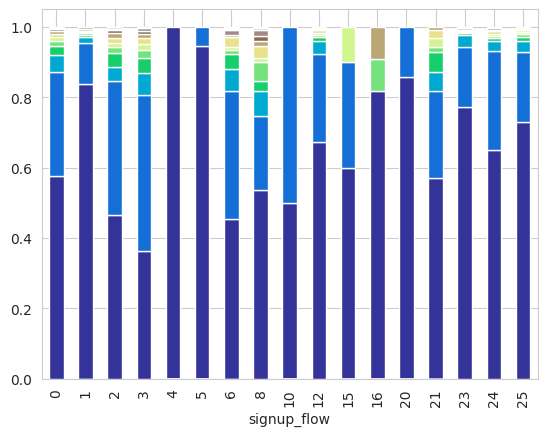

In [ ]:
stacked_bar('signup_flow')

The Signup Flow stacked bar chart raises very interesting observations: people with signup flow 3 are most likely to book an Airbnb. Conversely, people with signup flows 4 and 5 are least likely to convert.

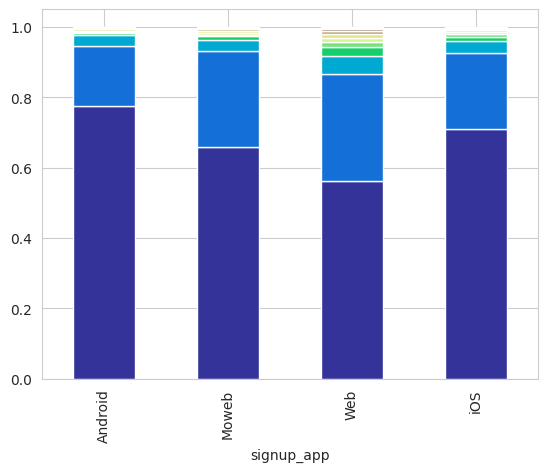

In [ ]:
stacked_bar('signup_app')

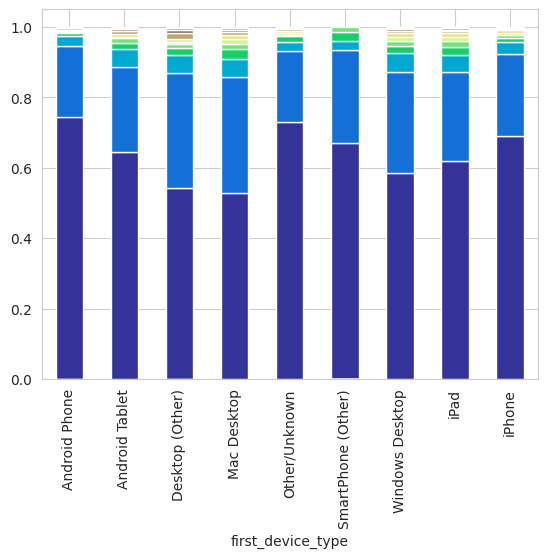

In [ ]:
stacked_bar('first_device_type')

As there are too many browsers, we will ignore it for the time being and try to reduce the categories in a later step. For now, we can make the following observations about User Devices:

Users using the Web App are most likely to book an Airbnb whereas Android Users are least likely to do so.
People with an Android Phone or whose devices were unknown bought fewer Airbnbs. People on Desktops (Mac or otherwise) bought more.
This strongly suggests that users on their desktop will be more likely to book an Airbnb and Apple Users are more prone to buying on the website whereas Android Users are the least.

In [ ]:
df_train['date_account_created'] = pd.to_datetime(df_train['date_account_created'])

<Axes: >

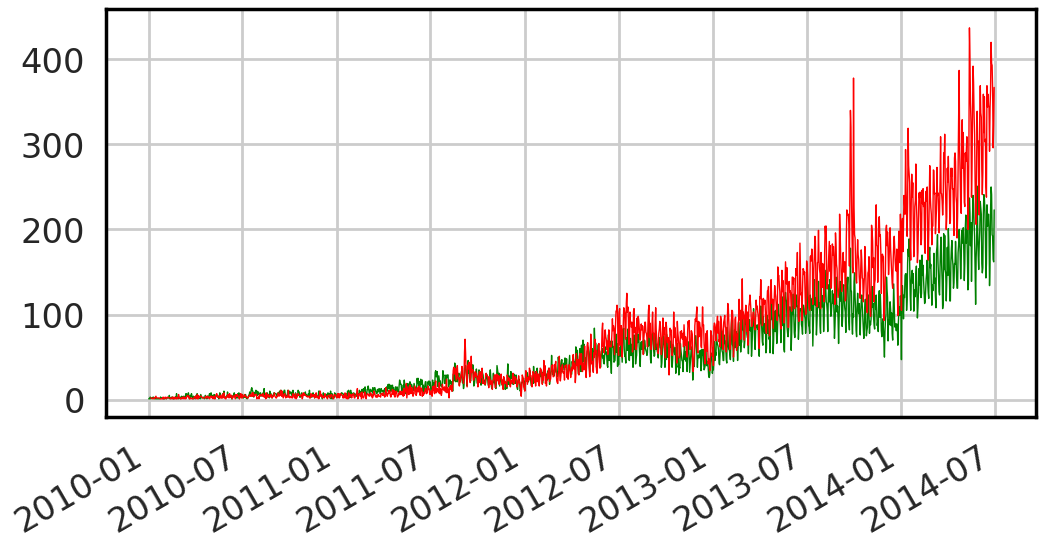

In [ ]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=1.1)
plt.figure(figsize=(12,6))

df_train[df_train['country_destination'] != 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='green')
df_train[df_train['country_destination'] == 'NDF']['date_account_created'].value_counts().plot(kind='line', linewidth=1, color='red')

The number of non booking users have increased more than the number of booking users as time passed by. This can be attributed to the fact that more people are using the platform just for exploration. Another reason might be that since the user was on the platform for a longer time, s/he was more likely to go ahead and book a space. This directly implies that the earlier the user had created an account on Airbnb, the more likelier s/he was to actually make a booking.

With all this in mind, we can nos proceed to the Feature Engineering Step. The Features that we have not yet explored in this section will be explored in the next.

Feature Engineering


Now, with all these visualisations and insights under our belt, let us proceed to build some new features that would help us get better predictions when we finally train our machine learning model. First, I'd like to extract features from our sessions dataset. Additionally, since we haven't done too much visualisation of our sessions, this would be a good place to do so.

In [ ]:
df_ses.head(2)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0


Session Features

The first feature I want to engineer is the number of devices a user accesses the app through. My hunch is that if the user uses a lot of devices, it implies s/he travels very often and hence, would be likely to book an Airbnb. An additional hypothesis is that if the person travels a lot, s/he must probably be a business traveler and hence would likely be inclined to book Airbnbs within the United States.

The second feature I want is the total number of seconds the user has spent on Airbnb Sessions. It will be interesting to see how this correlates with out classes.

The third feature is average seconds per session. Again, I do not have a lot of intuition behind this step but I have a feeling this feature may be useful.

The fourth feature is total number of sessions. As with total seconds, this might indicate greater interest. Additonally, we'll also construct a number of session types feature to further quantify the user's interest and engagement.

The final feature I want to look at is number of short sessions. These are sessions less than 300 seconds long. We will construct a number of long sessions by subtracting it from total number of sessions.

In [ ]:
def session_features(df):
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x: total_sessions[x] if x in total_sessions else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x: num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x: num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    return df

In [ ]:
def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

In [ ]:
def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'

In [ ]:
def devices(df):
    df['first_device_type'] = df['first_device_type'].apply(classify_device)
    return df

In [ ]:
def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

In [ ]:
def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'rest' if x not in ['direct', 'google', 'other'] else x)
    return df

In [ ]:
def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df

In [ ]:
def languages(df):
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df

In [ ]:
def first_booking(df):
    df = df.drop('date_first_booking', axis=1)
    return df

In [ ]:
def account_created(df):
    df = df.drop('date_account_created', axis=1)
    return df

In [ ]:
def feature_engineering(df):
    df = session_features(df)
    df = df.drop('age', axis=1)
    df = browsers(df)
    df =devices(df)
    df =affiliate_tracked(df)
    df = affiliate_provider(df)
    df = affiliate_channel(df)
    df = languages(df)
    df['is_3'] = df['signup_flow'].apply(lambda x: 1 if x==3 else 0)
    df = first_booking(df)
    df = df.drop('timestamp_first_active', axis=1)
    df = account_created(df)
    df = df.set_index('id')
    df = pd.get_dummies(df, prefix='is')
    return df

In [ ]:
total_seconds = df_ses.groupby('user_id')['secs_elapsed'].sum()

In [ ]:
average_seconds = df_ses.groupby('user_id')['secs_elapsed'].mean()

In [ ]:
total_sessions = df_ses.groupby('user_id')['action'].count()

In [ ]:
distinct_sessions = df_ses.groupby('user_id')['action'].nunique()

In [ ]:
num_short_sessions = df_ses[df_ses['secs_elapsed'] <= 300].groupby('user_id')['action'].count()
num_long_sessions = df_ses[df_ses['secs_elapsed'] >= 2000].groupby('user_id')['action'].count()

In [ ]:
num_devices = df_ses.groupby('user_id')['device_type'].nunique()

In [ ]:
df_train = session_features(df_train)

In [ ]:
df_train = df_train.drop('age', axis=1)

There are more than 50 categories of browsers although the majority use only 5. Therefore, we will club all the minor browsers into the 'Other' category.

Next, from our visualisation above, we saw that desktop users were most likely to book Airbnbs, followed by Tablet users, Phone users and finally people whose devices were unknown. Let us reduce first_device_type into these categories.

In [ ]:
df_train = browsers(df_train)

In [ ]:
df_train = devices(df_train)

In [ ]:
df_train = affiliate_tracked(df_train)

In [ ]:
df_train = affiliate_provider(df_train)

In [ ]:
df_train = affiliate_channel(df_train)

In [ ]:
df_train = languages(df_train)

we noticed that people with signup flow 3 had a disproportionate number of conversions. Therefore, we will define an additional feature that identifies these users. We will also revert back our gender fature by filling in the NaNs with Unknown since we deduced that it will lead to an improvement in prediction.

In [ ]:
df_train['is_3'] = df_train['signup_flow'].apply(lambda x: 1 if x==3 else 0)
df_train['gender'] = df_train['gender'].fillna('Unknown')

We will drop the first_bookings and the timsestamp features. This is because they do not add any value when finally testing the model with the test set. All our test users have NaNs as first booking and the timestamp is of no significance.

In [ ]:
df_train = first_booking(df_train)

In [ ]:
df_train = df_train.drop('timestamp_first_active', axis=1)

Finally we will drop the accounts created feature as our training and test sets were separated in the middle of 2014. As a result, all test users registered only in 2014.

In [ ]:
df_train = account_created(df_train)

In [ ]:
df_train = df_train.set_index('id')

In [ ]:
class_dict = {
    'NDF': 0,
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}

In [ ]:
X, y = df_train.drop('country_destination', axis=1), df_train['country_destination'].apply(lambda x: class_dict[x])

In [ ]:
X = pd.get_dummies(X, prefix='is')

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.75, stratify=y)

Model Selection

We need to however come up with a classifier that performs the best, given the features. In such competitions, Ensemble Methods give the best results. We will train our model using three classifiers: Gradient Boosting, Logistic Regression and Random Forest and choose the one with the best accuracy.

In [ ]:
classifiers = [RandomForestClassifier(verbose=1), LogisticRegression(verbose=1), GradientBoostingClassifier(verbose=True)]

for classifier in classifiers:
  classifier.fit(train_X, train_y)
  print("Score: " + str(classifier.score(test_X, test_y)))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


Score: 0.6225287184003898


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Score: 0.5834754417855068
      Iter       Train Loss   Remaining Time 
         1           1.1389            8.16m
         2           1.1217            6.88m
         3           1.1090            6.61m
         4           1.0996            6.39m
         5           1.0926            6.17m
         6           1.0870            5.92m
         7           1.0829            5.73m
         8           1.0795            5.71m
         9           1.0769            5.67m
        10           1.0745            5.97m
        20           1.0600            5.37m
        30           1.0517            4.74m
        40           1.0466            4.17m
        50           1.0421            3.58m
        60          33.8791            2.81m
        70          33.8755            2.05m
        80          33.8721            1.34m
        90          33.8691           39.33s
       100          33.8662            0.00s
Score: 0.6334351516968686


Logistic Regression is the least accurate classifier with a logged accuracy of less than 60%.
On average, the Gradient Boosting Classifier performed the best with accuracy close to 65%.
There are, of course, other classifiers that can be tested out in this step but I will stop here and choose the Gradient Boosting Classifier as my model of choice.

This classifier has an accuracy of approximately 65%. Let us try and improve this by using hyperparameter tuning using Grid Search Cross Validation. Fortunately, like always, scikit-learn has the tools available to us that reduces the amount of code to a bare minimum.

Hyperparameter Tuning using Grid Search Cross Validation

In [ ]:
parameters = {
    'n_estimators': [100,200],
    'max_features': [1, 'log2'],
    'max_depth': [3,5]
}

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, verbose=100)
clf.fit(train_X, train_y)

NameError: ignored

In [ ]:
clf.best_params_

The best paramaters obtained by Grid Search can be seen above. We will change the learning rate to 200 for best results.

 make predictions for our test users

In [ ]:
df_test = pd.read_csv(path + 'test_users.csv.zip')
df_test['gender'] = df_test['gender'].replace('-unknown-', 'Unknown')
df_test['age_group'] = df_test['age'].apply(set_age_group)
df_test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,age_group
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Young
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari,Unknown
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,Unknown
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,Unknown,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE,Unknown
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,Unknown,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,Unknown


In [ ]:
df_test = feature_engineering(df_test)
df_test = df_test.drop('is_weibo', axis=1)

In [ ]:
df_test.columns

In [ ]:
X.columns

In [ ]:
pred_prob = clf.predict_proba(df_test)

In [ ]:
pred_prob = pd.DataFrame(pred_prob, index=df_test.index)
pred_prob.head()

In [ ]:
inv_classes = {v: k for k, v in class_dict.items()}
inv_classes

In [ ]:
def get_top(s):
    indexes = [i for i in range(0,12)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [inv_classes[i[0]] for i in top_five]
    return str(top_five)

In [ ]:
pred_prob['get_top'] = pred_prob.apply(get_top, axis=1)
pred_prob.head()

In [ ]:
import ast
pred_prob['get_top'] = pred_prob['get_top'].apply(lambda x: ast.literal_eval(x))

In [ ]:
s = pred_prob.apply(lambda x: pd.Series(x['get_top']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'country'

In [ ]:
submission = pred_prob.drop([i for i in range(0,12)] + ['get_top'], axis=1).join(s)
submission.head()

 Several classifiers were considered and the Gradient Boosting Classfier was selected and its paramters were tuned. This classifer was used to predict the destination of our test users and a submission file was created in the format suggested by Airbnb.

 This score can be improved through more hyperparameter tuning and more advanced feature engineering but the improvement is extremely minimal (considering that the highest score was 0.88).